In [2]:
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from folium.plugins import MarkerCluster
from scipy.stats import chi2_contingency


## Research Question: What trends can be observed in the diversity of Nobel Prize winners over time, in terms of gender, nationality, and other related factors?
## 0. Authors
- Wenting Chen
- Hyun Choi
- Hongchao Hu
- Shentong Li


## 1. Data Resources
### Database Content License (DbCL)

- **Dataset (`geo_df`):** Nobel Prize Laureates
  - **Source:** [Kaggle Dataset by Joe Beach Capital](https://www.kaggle.com/datasets/joebeachcapital/nobel-prize?rvi=1&select=nobel-prize-laureates.csv)
  - **License:** Database Contents License (DbCL)

### Software License

- **Dataset (`df`):** Nobel Prize Data
  - **Source:** [Kaggle Dataset by Shayal Vaghasiya](https://www.kaggle.com/datasets/shayalvaghasiya/nobel-prize-data)
  - **License:** MIT License


## 2. Data Description
`geo_df` lists all Nobel laureates (persons and organizations) from 1902. We need this dataset because we can get the longitude and the latitude in `Geo Point 2D`, which allows us to do geospatial analysis.
- `Id`: A unique identifier for each laureate.
- `Firstname`: The first name of the Nobel laureate.
- `Surname`: The surname of the Nobel laureate.
- `Born`: The birth date of the laureate.
- `Died`: The death date of the laureate, if applicable.
- `Born country`: The country where the laureate was born.
- `Born country code`: The ISO country code corresponding to the laureate's birth country.
- `Born city`: The city where the laureate was born.
- `Died country`: The country where the laureate died, if applicable.
- `Died country code`: The ISO country code for the country where the laureate died.
- `Died city`: The city where the laureate died.
- `Gender`: The gender of the laureate.
- `Year`: The year the Nobel Prize was awarded.
- `Category`: The category of the Nobel Prize (e.g., Physics, Chemistry, Medicine, Literature, Peace, Economic Sciences).
- `Overall motivation`: A general motivation for the award, if provided.
- `Motivation`: The specific motivation for awarding the Nobel Prize to the laureate.
- `Organization name`: The name of the organization associated with the laureate at the time of the award.
- `Organization city`: The city where the associated organization is located.
- `Organization country`: The country where the associated organization is located.
- `Geo Shape`: A geographical shape data, possibly indicating the location of the organization or a related geographic attribute.
- `Geo Point 2D`: Two-dimensional geographic coordinates, likely representing the latitude and longitude of the organization or another relevant location.


In [3]:
geo_df = pd.read_csv('./nobel-prize-laureates.csv', sep=';')
geo_df.head(2)

,Id,Firstname,Surname,Born,Died,Born country,Born country code,Born city,Died country,Died country code,...,Gender,Year,Category,Overall motivation,Motivation,Organization name,Organization city,Organization country,Geo Shape,Geo Point 2D
0,820,Leonid,Hurwicz,1917-08-21,2008-06-24,Russia,RU,Moscow,USA,US,...,male,2007,Economics,NaN,"""for having laid the foundations of mechanism ...",University of Minnesota,Minneapolis MN,USA,"{""coordinates"": [[[[-155.60651897, 20.13795556...","45.68753333949257, -112.49433391594603"
1,28,Robert A.,Millikan,1868-03-22,1953-12-19,USA,US,Morrison IL,USA,US,...,male,1923,Physics,NaN,"""for his work on the elementary charge of elec...",California Institute of Technology (Caltech),Pasadena CA,USA,"{""coordinates"": [[[[-155.60651897, 20.13795556...","45.68753333949257, -112.49433391594603"


`df` contains the most prestigious international awards since 1901. Each year, awards are bestowed in chemistry, literature, physics, physiology or medicine, economics, and peace. We need this dataset for analyzing the relationship between the Nobel Prize and the `sex`, `prize_share` (individual winner or group winner), `year`. 

- `year`: The year in which the Nobel Prize was awarded.
- `category`: The category of the Nobel Prize (e.g., Physics, Chemistry, Medicine, Literature, Peace, Economic Sciences).
- `prize`: The name or title of the Nobel Prize awarded.
- `motivation`: The official explanation provided for why the Nobel Prize was awarded to the laureate.
- `prize_share`: Indicates the fraction of the prize that was awarded to the laureate, reflecting whether the prize was shared among multiple recipients.
- `laureate_id`: A unique identifier for each laureate.
- `laureate_type`: Specifies whether the laureate is an individual or an organization.
- `full_name`: The full name of the laureate.
- `birth_date`: The birth date of the laureate.
- `birth_city`: The city where the laureate was born.
- `birth_country`: The country where the laureate was born.
- `sex`: The gender of the laureate.
- `organization_name`: The name of the organization associated with the laureate at the time of receiving the Nobel Prize.
- `organization_city`: The city where the associated organization is located.
- `organization_country`: The country where the associated organization is located.
- `death_date`: The date of death for the laureate, if applicable.
- `death_city`: The city where the laureate died, if applicable.
- `death_country`: The country where the laureate died, if applicable.

In [4]:
df = pd.read_csv('./nobel.csv')
df.head(2)

,year,category,prize,motivation,prize_share,laureate_id,laureate_type,full_name,birth_date,birth_city,birth_country,sex,organization_name,organization_city,organization_country,death_date,death_city,death_country
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,160,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Male,Berlin University,Berlin,Germany,1911-03-01,Berlin,Germany
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,569,Individual,Sully Prudhomme,1839-03-16,Paris,France,Male,NaN,NaN,NaN,1907-09-07,Châtenay,France


## 3. Previous Work and What's New in Ours

### 3.1 Previous Research

#### Previous Work 1:

- **Title:** Disparities in funding for Nobel Prize awards in medicine and physiology across nationalities, races, and gender.
- **Source:** [PubMed](https://pubmed.ncbi.nlm.nih.gov/38225913)
- **Key Points:**
  - Analyzed the diversity of Nobel Prize winners in Physiology and Medicine.
  - Highlighted disparities in gender, race, and nationality.
  - Focused particularly on the underrepresentation of Black scientists and the predominance of American laureates.

#### Previous Work 2:

- **Title:** The Nobel Prizes’ Diversity Problem in Science
- **Source:** [US News](https://www.usnews.com/news/best-countries/articles/2020-10-01/the-nobel-prizes-have-a-diversity-problem-worse-than-the-scientific-fields-they-honor)
- **Key Points:**
  - Discussed systemic issues of the Nobel Prize's lack of diversity.
  - Highlighted the underrepresentation of women and Black scientists among laureates, especially in Chemistry.

### 3.2 New in Our Project

- **Enhancements Over Previous Research:**
  - **Broadened Scope:** Unlike the previous works focusing on specific fields, our project expands the analysis across all Nobel Prize categories, providing a comprehensive examination of trends over time.
  - **Inclusive Analysis:** We include an extensive analysis of gender, nationality, and ethnicity, thereby offering a more detailed understanding of diversity among Nobel laureates.
  - **Time-Series Examination:** Our work introduces a time-series analysis to track changes and developments in diversity patterns among Nobel Prize winners over the years.
  - **Interdisciplinary Focus:** By covering all categories, we also shed light on how interdisciplinary achievements are recognized in the context of Nobel Prizes, considering the growing importance of cross-disciplinary innovations.

> Our study aims to fill the gaps identified in previous research by providing an all-encompassing view of diversity within the Nobel Prize laureates, fostering a deeper understanding of the systemic issues at play and offering insights into areas for improvement in recognizing global contributions to science, literature, and peace.

## 4. Analysis Methods Used

Our research utilized a comprehensive set of statistical and analytical methods to explore various aspects of Nobel Prize winners' diversity. Below, we detail the methods used and the specific purpose of using them.

- **Chi-Squared Testing:** To examine whether there are significant differences in the distribution of Nobel Prize winners across different categories based on gender, nationality, and ethnicity.
- **Hypothesis Testing:** To test specific hypotheses related to disparities and trends in Nobel Prize distributions, such as underrepresentation of certain groups.

- **Inferential Analysis:** To infer broader trends and patterns from sample data, particularly regarding the representation of diverse groups among laureates.

- **Descriptive Analysis:** To provide a detailed description of the dataset, including the distribution of prizes by category, gender, nationality, and other demographic variables.

- **Geospatial Analysis:**  To analyze the geographical distribution of Nobel laureates, focusing on the birthplaces and the representation of different regions.

- **Regression Method:** To identify trends and predict future patterns in the data, such as the increasing or decreasing representation of certain groups among winners.

- **Causal Analysis:** To investigate potential causal relationships within the data, such as the impact of specific factors (e.g., geopolitical events, scientific breakthroughs) on Nobel Prize distributions.

## 5.EDA 
### 5.1 Distribution of Nobel Prizes Over Time (`geo_df` used)
Providing insight into the historical trends of Nobel Prize awards, highlighting periods of increased or decreased activity, which can reflect global events and shifts in the scientific community's focus.

/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


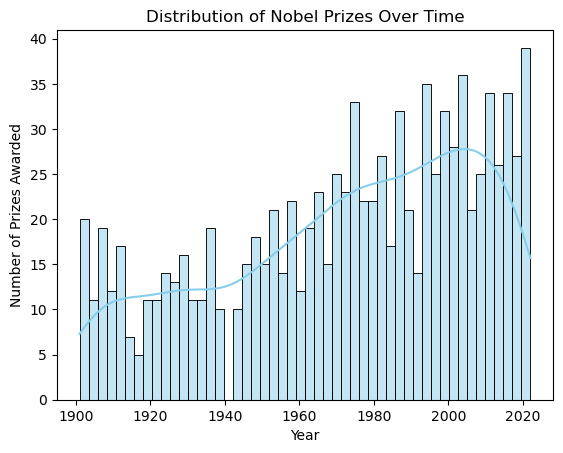

In [4]:
sns.histplot(data=geo_df, x='Year', bins=50, color='skyblue', kde=True)
plt.title('Distribution of Nobel Prizes Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Prizes Awarded')
plt.show()

### 5.2 Nobel Prizes Distribution by Category (`df` used)
Understanding the distribution of Nobel Prizes across different categories reveals the evolving priorities and advancements in fields of science, literature, and peace.


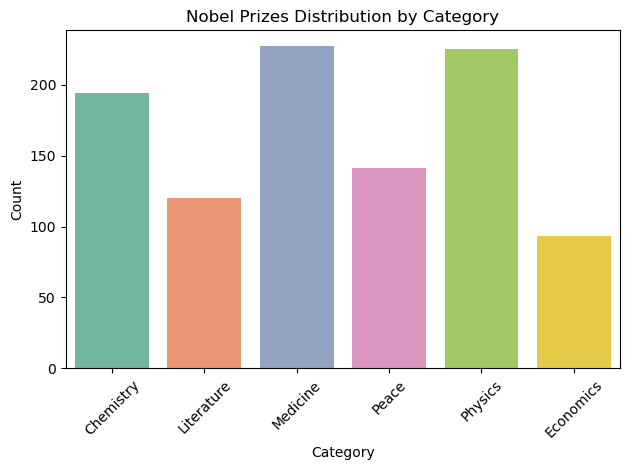

In [5]:
# count plot of Nobel Prizes by category
sns.countplot(data=df, x='category', palette='Set2')
plt.title('Nobel Prizes Distribution by Category')
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 5.3 Analysis of Collaborative Work Over Time (`df` used)
To explore how the nature of Nobel Prize-winning work has shifted towards individual versus collaborative efforts.

In [6]:
df_collaborative = df[df['prize_share'] != '1/1']

# Calculate the mean number of laureates per prize for each year and category for collaborative work
collaboration_over_time = df_collaborative.groupby(['year', 'category']).size().groupby(level=0).mean()
collaboration_over_time.head(1)

year
1901    2.0
dtype: float64

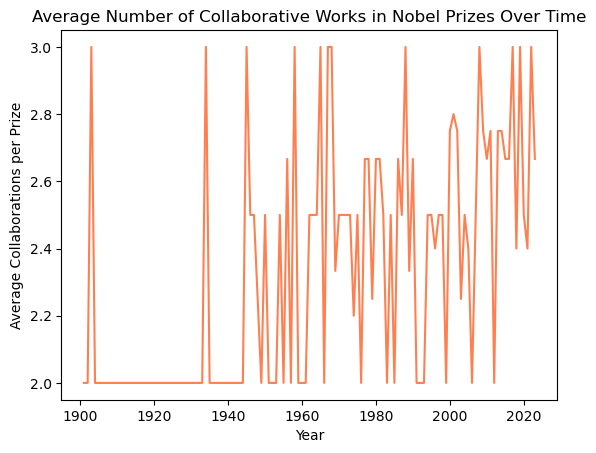

In [7]:
collaboration_over_time.plot(kind='line', color='coral')
plt.title('Average Number of Collaborative Works in Nobel Prizes Over Time')
plt.xlabel('Year')
plt.ylabel('Average Collaborations per Prize')
plt.show()

### 5.4 Trends in Specific Categories Over Time (`df` used)
How the distribution of prizes in a specific category `Peace` has changed over time can highlight shifts in scientific focus or societal values.

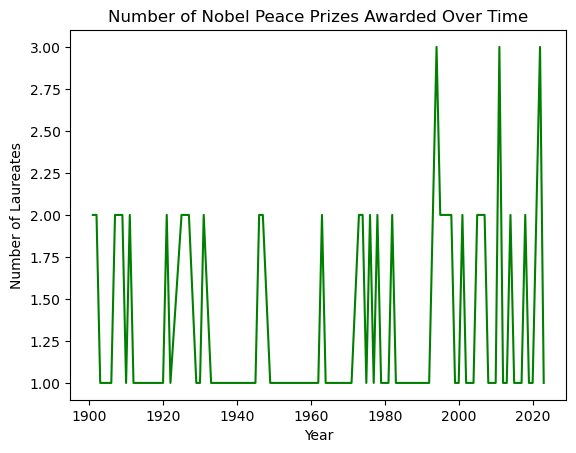

In [8]:
# line plot of the number of laureates in the 'Peace' category over time
peace_prizes = df[df['category'] == 'Peace']
peace_prizes_yearly = peace_prizes.groupby('year').size()

peace_prizes_yearly.plot(kind='line', color='green')
plt.title('Number of Nobel Peace Prizes Awarded Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Laureates')
plt.show()

### 5.5 Correlation Analysis Between Prize Share and `year` (`df` used)
Exploring correlations can help identify if certain factors are associated with the likelihood of sharing a prize.

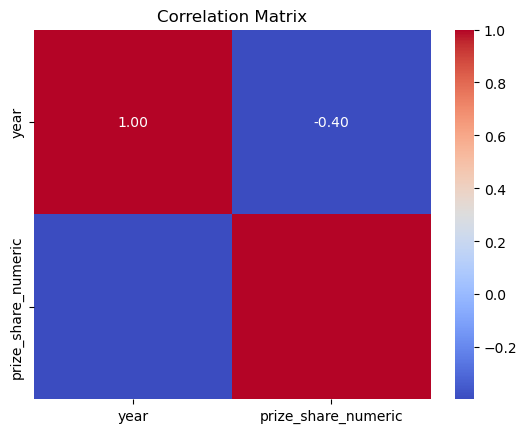

In [9]:
# convert to numerical col
df['prize_share_numeric'] = df['prize_share'].apply(lambda x: 1/int(x.split('/')[1]))
correlation_matrix = df[['year', 'prize_share_numeric']].corr()

# the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## 6. Gender Analysis Over Time
### 6.1 Has the gender distribution among Nobel Prize laureates across all categories shown significant disparity over the period from 1901 to 2022?

- Null Hypothesis (H0): There is no significant gender disparity in the distribution of Nobel Prize laureates across all categories from the time period from 1901 to 2022.

- Alternative Hypothesis (H1): There is a significant gender disparity in the distribution of Nobel Prize laureates over the time period from 1901 to 2022, favoring males over females.

In [10]:
# use test statistic to prove that number of male is significantly higher than female
# dropped = df.drop(['death_city', 'death_country', 'death_date'], axis=1)
df_gender = df.copy()
df_gender['sex'].value_counts()

sex
Male      905
Female     65
Name: count, dtype: int64

In [11]:
# number of male and female laureats each year in line plot
num_gender_year = df_gender.groupby(['year', 'sex']).size().unstack(fill_value=0)
num_gender_year

sex,Female,Male
year,,
1901,0,6
1902,0,7
1903,1,6
1904,0,5
1905,1,4
...,...,...
2019,1,13
2020,4,7
2021,1,12


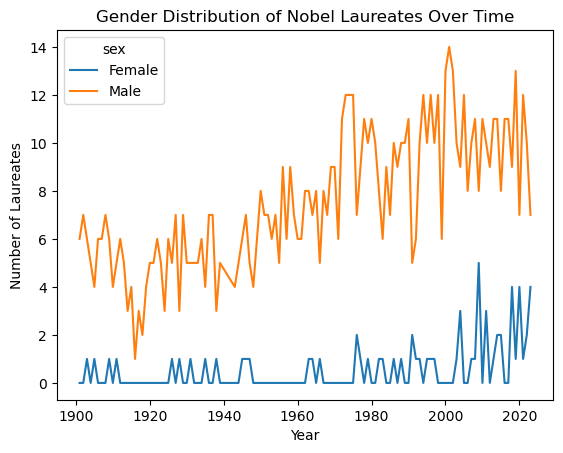

In [12]:
num_gender_year.plot(kind='line')
plt.title('Gender Distribution of Nobel Laureates Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Laureates')
plt.show()

In [13]:
# calculating chi-square value of overall distribution of nobel prize laureates between gender
observed = df_gender['sex'].value_counts()

expected = [observed.sum() / 2, observed.sum() / 2]

chi2, p_value, _, _ = chi2_contingency([observed, expected])

print(f"Chi-squared Statistic: {chi2}, P-value: {p_value}")

Chi-squared Statistic: 445.50469587965995, P-value: 6.861656148752313e-99


> The comprehensive analysis of the overall distribution of Nobel Prize laureates between males and females indicates a significant gender disparity, with males receiving a significantly higher number of awards than females. The Chi-squared test yielded a p-value of 6.86e-99, which indicates the extreme gender disparity with a highly unlikely possiblity by chance under the null hypothesis of equal gender probability. Additionally, the line plots comparing male and female laureates across all categories makes it more evident, with males consistently outnumbering females in award count.

### 6.2 Does the gender disparity among Nobel Prize laureates vary across specific categories over the time period 1901 to 2020?

- Null Hypothesis (H0): The gender disparity among Nobel Prize laureates is consistent across different categories, suggesting a uniform pattern of gender distribution within each category.

- Alternative Hypothesis (H1): The degree of gender disparity varies significantly across different Nobel Prize categories, indicating disparities in gender exists across various fields.

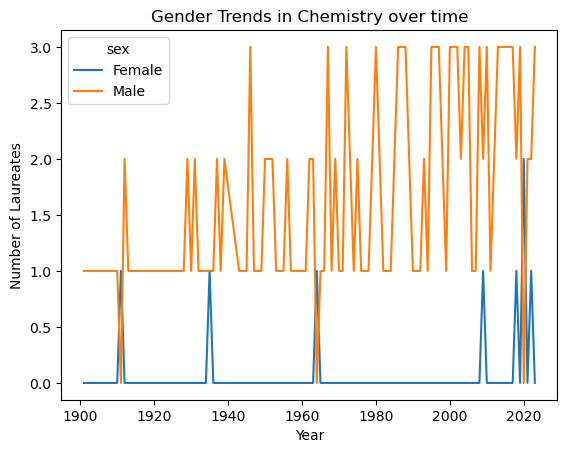

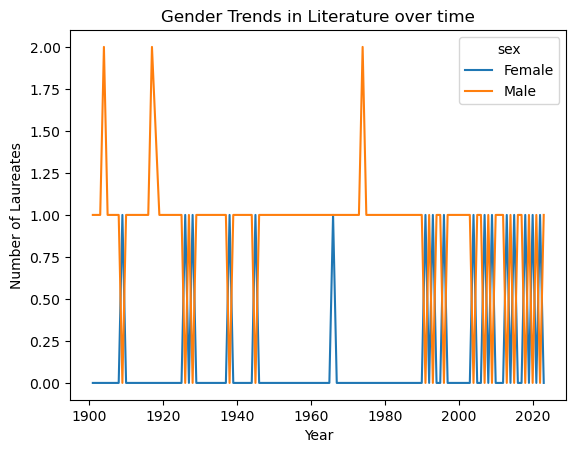

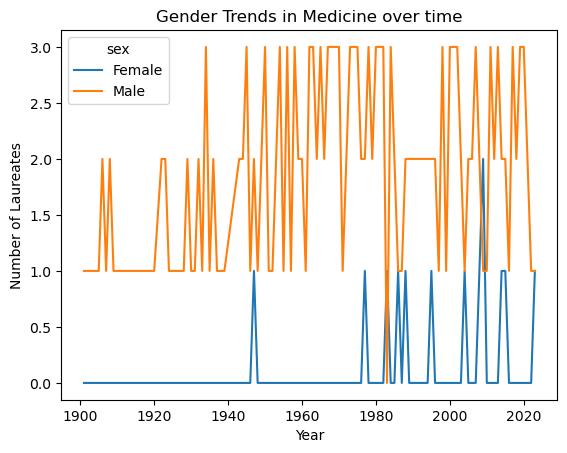

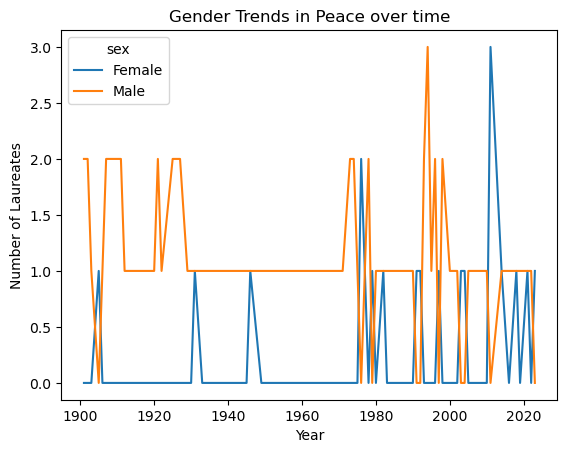

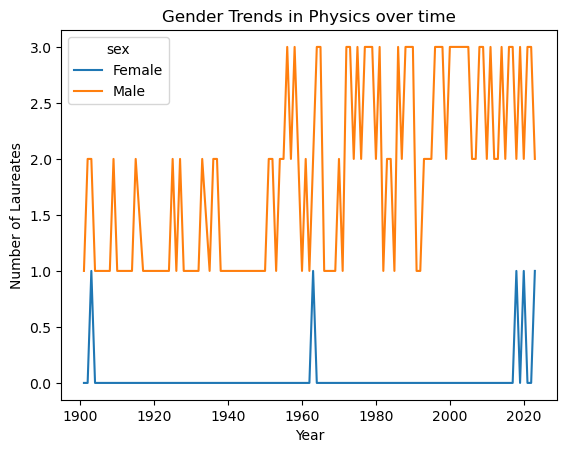

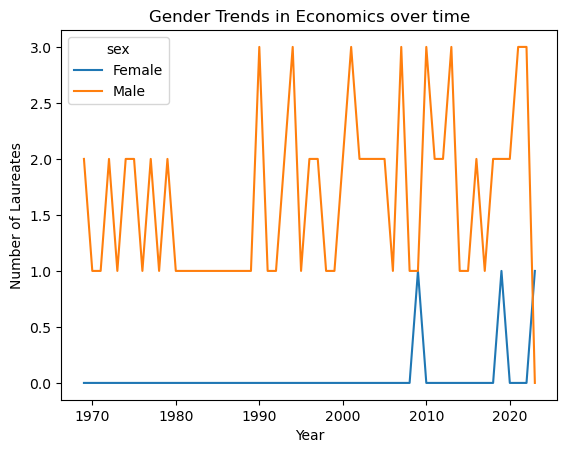

In [14]:
# type of prize and getnder trends over time
unique_category = list(df_gender['category'].unique())

for category in unique_category:
    df_category = df_gender[df_gender['category'] == category]
    gender_category_time = df_category.groupby(['year', 'sex']).size().unstack(fill_value=0)
    gender_category_time.plot(kind='line')
    plt.title(f'Gender Trends in {category} over time')
    plt.ylabel('Number of Laureates')
    plt.xlabel('Year')
    plt.show()

In [15]:
# calculating chi-square value of distribution of each specified category nobel prize laureates between gender
observed_frequencies = df_gender.groupby(['category', 'sex']).size().unstack(fill_value=0)

results = {}
for category in observed_frequencies.index:
    observed = observed_frequencies.loc[category].values
    total = observed.sum()
    expected = np.array([total / 2, total / 2])

    # chi-squared test for specific categories
    chi2, p_value, dof, _ = chi2_contingency(np.array([observed, expected]))
    results[category] = p_value

# For the overall chi-squared test across all categories
chi2_overall, p_value_overall, dof_overall, _ = chi2_contingency(observed_frequencies)

print("P-Value for Overall Gender Disparity:", p_value_overall)
print("P-Values for Each Category:\n", results)

P-Value for Overall Gender Disparity: 7.855336377892735e-08
P-Values for Each Category:
 {'Chemistry': 8.673648325651831e-24, 'Economics': 1.771032328469277e-12, 'Literature': 6.32783747491357e-09, 'Medicine': 2.096297293861613e-25, 'Peace': 4.516094921173879e-07, 'Physics': 2.9656902860613777e-30}


> The analysis by each category supports the overall finding of male dominance in Nobel Prizes but also reveals variances in the degree of gender disparity across categories.Specifically, the Peace category of the Nobel Prizes shows a slightly less significant disparity, with a p-value of 4.51e-07, though still far from suggesting gender parity. In stark contrast, Physics exhibits the most significant gender gap, with a p-value of 2.96e-30. Line plots across categories further highlight gender inequalities in Nobel Prize awards.

### 6.3 Trend Analysis

Both analyses underscore a positive trend towards increased female laureateship over time. Prior to 2000, female laureates were exceedingly rare, but there has been a noticeable uptick in female Nobel Prize awards in the years since, signaling a slow but steady move towards gender parity among Nobel laureates.

---

## 7. Birth Country Analysis Over Time

### 7.0 Geospatial Analysis

In [16]:
geo_df = geo_df.dropna(subset=['Geo Point 2D'])
geo_df.shape

(631, 21)

In [17]:
geo_df[['Latitude', 'Longitude']] = geo_df['Geo Point 2D'].str.split(', ', expand=True)

In [18]:
geo_df['Latitude'], geo_df['Longitude'] = zip(*geo_df['Geo Point 2D'].apply(lambda x: x.split(', ')))
geo_df['Latitude'] = pd.to_numeric(geo_df['Latitude'], errors='coerce')
geo_df['Longitude'] = pd.to_numeric(geo_df['Longitude'], errors='coerce')

# create the GeoDataFrame
gdf = gpd.GeoDataFrame(geo_df, geometry=gpd.points_from_xy(geo_df.Longitude, geo_df.Latitude))


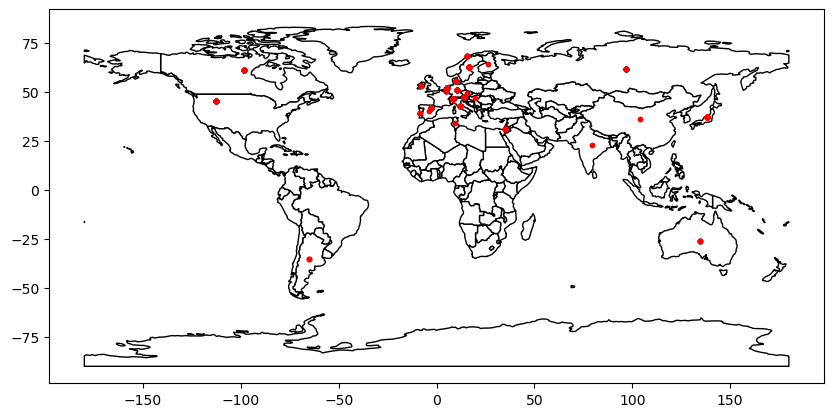

In [19]:
# distribution of nobel prize winner over world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6), color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=10)
plt.show()

In [20]:
# distribution of nobel prize winner over world
nobel_counts = geo_df.groupby('Born country code').size().reset_index(name='Count')

geo_df = pd.merge(geo_df, nobel_counts, on='Born country code', how='left')

gdf = gpd.GeoDataFrame(geo_df, geometry=gpd.points_from_xy(geo_df.Longitude, geo_df.Latitude))

m = folium.Map(location=[20, 0], zoom_start=2)

for idx, row in gdf.iterrows():
    popup_str = f"Number of Nobel Prize Winners: {row['Count']}"
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        popup=popup_str,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(m)

m
# interact with the map by clicking on the dots!

### 7.1 Is there a significant difference in the gender distribution of Nobel Prize winners between Western and Non-Western countries?
- Null Hypothesis (H0): There is no significant difference in the gender distribution of Nobel Prize winners between Western and Non-Western countries.

- Alternative Hypothesis (H1): There is a significant difference in the gender distribution of Nobel Prize winners between Western and Non-Western countries.

In [21]:
def classify_western(longitude):
    if -180 <= longitude <= 0:
        return 1  # Western
    else:
        return 0  # Nonwestern
geo_df['Is_Western'] = geo_df['Longitude'].apply(classify_western)
geo_df.head(1)

,Id,Firstname,Surname,Born,Died,Born country,Born country code,Born city,Died country,Died country code,...,Motivation,Organization name,Organization city,Organization country,Geo Shape,Geo Point 2D,Latitude,Longitude,Count,Is_Western
0,820,Leonid,Hurwicz,1917-08-21,2008-06-24,Russia,RU,Moscow,USA,US,...,"""for having laid the foundations of mechanism ...",University of Minnesota,Minneapolis MN,USA,"{""coordinates"": [[[[-155.60651897, 20.13795556...","45.68753333949257, -112.49433391594603",45.687533,-112.494334,17,1


In [22]:
contingency_table = pd.crosstab(geo_df['Is_Western'], geo_df['Gender'])
contingency_table

Gender,female,male
Is_Western,,
0,6,193
1,18,414


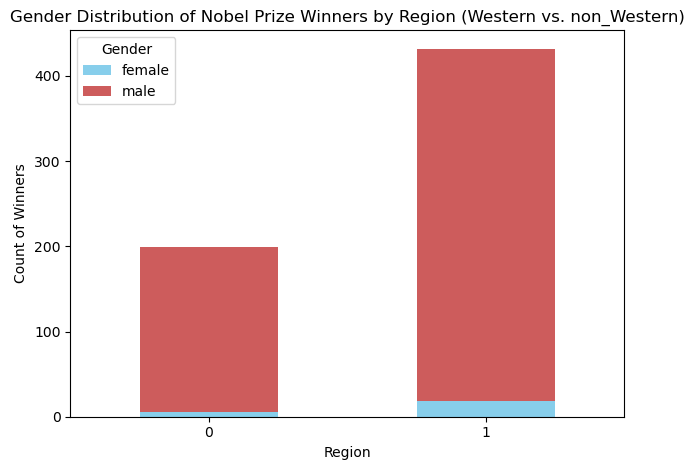

In [23]:
contingency_table.plot(kind='bar', stacked=True, color=['SkyBlue', 'IndianRed'])
plt.title('Gender Distribution of Nobel Prize Winners by Region (Western vs. non_Western)')
plt.xlabel('Region')
plt.ylabel('Count of Winners')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.tight_layout()

plt.show()

In [24]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2}, p-value: {p}")

Chi-square Statistic: 0.22922211281629112, p-value: 0.6321012208846553


> Given the chi-square statistic of approximately 0.229 and a p-value of approximately 0.632, the analysis suggests that we fail to reject the null hypothesis. The p-value significantly exceeds the commonly used alpha level of 0.05, indicating that there is no statistically significant difference in the gender distribution of Nobel Prize winners between Western and Non-Western countries.

### 7.2 Has the proportion of Nobel Prizes in `Physics` awarded to individuals from western versus nonwestern countries experienced significant changes over the period from 1901 to 2023?
- Null Hypothesis (H0): There is no significant temporal change in the proportion of Nobel Prizes in Physics awarded to laureates from western and nonwestern countries between 1901 and 2022. (This suggests that the geographic origin of Physics Nobel laureates has remained consistent over time.)

- Alternative Hypothesis (H1): The proportion of Nobel Prizes in Physics awarded to laureates from western versus nonwestern countries has experienced significant fluctuations between 1901 and 2022. (This indicates a change in the geographic distribution of recognized scientific achievements in Physics over the studied period.)

In [25]:
physics_df = geo_df[(geo_df['Category'] == 'Physics') & (geo_df['Year'].between(1900, 2023))]

yearly_counts = physics_df.groupby(['Year', 'Is_Western']).size().unstack(fill_value=0)

yearly_counts['Total'] = yearly_counts.sum(axis=1)
yearly_counts['Western_Prop'] = yearly_counts[1] / yearly_counts['Total']
yearly_counts['Non_Western_Prop'] = yearly_counts[0] / yearly_counts['Total']
yearly_counts.head(2)

Is_Western,0,1,Total,Western_Prop,Non_Western_Prop
Year,,,,,
1901,1,0,1,0.0,1.0
1902,2,0,2,0.0,1.0


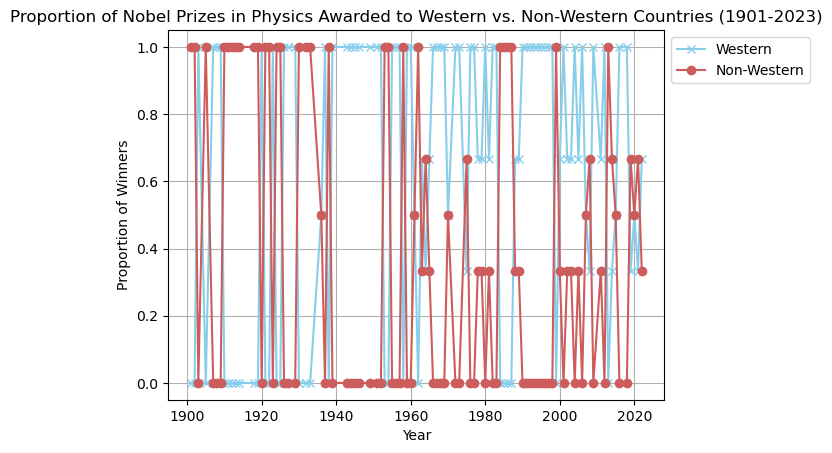

In [26]:
# Plotting both proportions over time
yearly_counts['Western_Prop'].plot(kind='line', marker='x', color='SkyBlue', label='Western')
yearly_counts['Non_Western_Prop'].plot(kind='line', marker='o', color='IndianRed', label='Non-Western')

plt.title('Proportion of Nobel Prizes in Physics Awarded to Western vs. Non-Western Countries (1901-2023)')
plt.xlabel('Year')
plt.ylabel('Proportion of Winners')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [27]:
# Chi-Square Test for Trend
physics_df = geo_df[(geo_df['Category'] == 'Physics') & (geo_df['Year'].between(1901, 2023))].copy()
physics_df['Decade'] = (physics_df['Year'] // 10) * 10
contingency_table = pd.crosstab(physics_df['Decade'], physics_df['Is_Western'])
contingency_table.head(2)

Is_Western,0,1
Decade,,
1900,4,5
1910,7,0


In [28]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 33.156210593556416, p-value: 0.0009151385980377344


> Given the p-value of 0.0009 is less than the conventional significance level of 0.05, we have sufficient evidence to reject the null hypothesis (H0). This suggests that there has been a significant change in the proportion of Nobel Prizes in Physics awarded to individuals from western versus nonwestern countries over the specified period.

### 7.3 How has the geographic dominance (i.e., the most frequent winner's region) in each Nobel Prize category changed over time?

In [32]:
# group the data by category and decade
geo_df['Decade'] = (geo_df['Year'] // 10) * 10
grouped = geo_df.groupby(['Category', 'Decade', 'Born country code']).size().reset_index(name='Count')

grouped.sort_values(by=['Category', 'Decade', 'Count'], ascending=[True, True, False], inplace=True)

# calculate the most represented region in each category over each decade to observe shifts in geographic dominance.
dominant_regions = grouped.drop_duplicates(subset=['Category', 'Decade'], keep='first')
dominant_regions.head(2)

,Category,Decade,Born country code,Count
0,Chemistry,1900,DE,3
6,Chemistry,1910,FR,3


In [33]:
pivot_dominant_regions = dominant_regions.pivot(index='Decade', columns='Category', values='Born country code')

print(pivot_dominant_regions)

Category Chemistry Economics Medicine Peace Physics
Decade                                             
1900            DE       NaN       PL    FR      DE
1910            FR       NaN       FR   NaN      DE
1920            DE       NaN       DK   NaN      DE
1930            DE       NaN       US    US      US
1940            US       NaN       US   NaN      PL
1950            US       NaN       US    US      US
1960            US        NL       US    US      US
1970            US        US       US   NaN      US
1980            US        US       US   NaN      US
1990            US        US       US   NaN      US
2000            US        US       US   NaN      US
2010            US        US       US   NaN      US
2020            US        US       US   NaN      DE


> The dataset illustrates the evolution of global scientific leadership over the past century, highlighting the shift from European to American dominance in several key Nobel Prize categories. This shift mirrors broader historical, economic, and scientific trends. The sustained dominance of the US across multiple decades underscores its role as a hub of scientific innovation. The variability in the Peace category reflects the global nature of peace efforts. Lastly, recent data points hint at possible emerging shifts in dominance, warranting close observation in the coming years to understand future trends in global scientific and peace contributions.

Given the data indicates a gradual shift in the distribution of Nobel laureates from Europe to other regions, which prize category demonstrates the most pronounced shift?

### 7.4 Which Nobel Prize category has shifted the most from European to other areas over time?

In [34]:
def is_in_europe(lat, lon):
    return -25.0 <= lon <= 40.0 and 34.0 <= lat <= 71.0

geo_df['Is_European'] = geo_df.apply(lambda row: is_in_europe(row['Latitude'], row['Longitude']), axis=1)
geo_df['Period'] = geo_df['Year'].apply(lambda x: 'Before 1960' if x < 1960 else 'After 1960')
european_winners = geo_df[geo_df['Is_European']].groupby(['Category', 'Period']).size().unstack(fill_value=0)

total_winners = geo_df.groupby(['Category', 'Period']).size().unstack(fill_value=0)

# the proportion of European winners
proportion_european_winners = european_winners / total_winners

# the shift by subtracting the proportions of the two periods
proportion_european_winners['Shift'] = proportion_european_winners['After 1960'] - proportion_european_winners['Before 1960']

# identifying the category with the most significant shift
most_significant_shift = proportion_european_winners['Shift'].idxmin()  # a negative shift means moving away from Europe

print("Category with the most significant shift from Europe:", most_significant_shift)
print(proportion_european_winners)

Category with the most significant shift from Europe: Chemistry
Period     After 1960  Before 1960     Shift
Category                                    
Chemistry    0.229358     0.764706 -0.535348
Economics    0.083333          NaN       NaN
Medicine     0.222222     0.530303 -0.308081
Peace        0.000000     0.333333 -0.333333
Physics      0.266667     0.535714 -0.269048


> The Chemistry category exhibits the most significant shift with a decrease of approximately 53.5% in the proportion of awards going to European laureates when comparing the period after 1960 to before 1960. This substantial change indicates a diversification in the geographic distribution of laureates in this field, with non-European recipients becoming much more prevalent in recent decades.

Since the US is keeping being dominant, we now want to analyze whether the proportion of Nobel Prizes awarded to winners from the United States is significantly different between the early years (starting 1901) and recent years (up to 2023).

### 7.5 Has the proportion of Nobel Prizes awarded to winners from the United States significantly changed between the early 20th century (1901-1960) and the early 21st century (1961-2023)?

- Null Hypothesis (H0): There is no significant difference in the proportion of Nobel Prizes awarded to US winners between the early 20th century (1901-1960) and the early 21st century (1961-2023).

- Alternative Hypothesis (H1): There is a significant difference in the proportion of Nobel Prizes awarded to US winners between the early 20th century (1901-1960) and the early 21st century (1961-2023).

In [35]:
geo_df['Is_US'] = geo_df['Born country code'] == 'US'

# Splitting the dataset into two periods
early_period = geo_df[(geo_df['Year'] >= 1901) & (geo_df['Year'] <= 1960)]
recent_period = geo_df[(geo_df['Year'] >= 1961) & (geo_df['Year'] <= 2023)]

# the count of US and non-US winners in each period
early_us_count = early_period['Is_US'].sum()
early_non_us_count = len(early_period) - early_us_count
recent_us_count = recent_period['Is_US'].sum()
recent_non_us_count = len(recent_period) - recent_us_count

contingency_table = np.array([[early_us_count, early_non_us_count],
                              [recent_us_count, recent_non_us_count]])
contingency_table

array([[ 42, 137],
       [216, 236]])

In [36]:
# Performing Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2}, p-value: {p}")

Chi-square Statistic: 30.389386403200525, p-value: 3.534567949601568e-08


> The statistical analysis, yielding a chi-square statistic of 30.39 and a p-value of approximately 3.53e-08, conclusively rejects the null hypothesis, indicating a significant difference in the proportion of Nobel Prizes awarded to US recipients between the periods 1901-1960 and 1961-2023. This significant shift highlights an increasing dominance of the United States in Nobel Prize recognitions across various categories, reflecting broader global scientific and cultural trends that have positioned the US as a leading center for excellence and innovation in the latter half of the 20th century and into the 21st century.

### 7.6 Is the distribution of Nobel Prize sharing (individual vs. group) significantly associated with the laureates' birth countries?

- Null Hypothesis (H0): There is no significant association between the laureates' birth countries and the distribution of Nobel Prize sharing (individual vs. group).

- Alternative Hypothesis (H1): There is a significant association between the laureates' birth countries and the distribution of Nobel Prize sharing, indicating that the preference or trend towards individual versus group Nobel Prizes varies by birth country.

In [37]:
df['Prize_Individual'] = df['prize_share'].apply(lambda x: 1 if x == '1/1' else 0)

contingency_table = pd.crosstab(df['birth_country'], df['Prize_Individual'])
contingency_table

Prize_Individual,0,1
birth_country,,
Argentina,2,2
Australia,10,0
Austria,11,5
Austria-Hungary (Austria),0,1
Austria-Hungary (Bosnia and Herzegovina),1,0
...,...,...
Venezuela,1,0
Vietnam,1,0
W&uuml;rttemberg (Germany),0,1


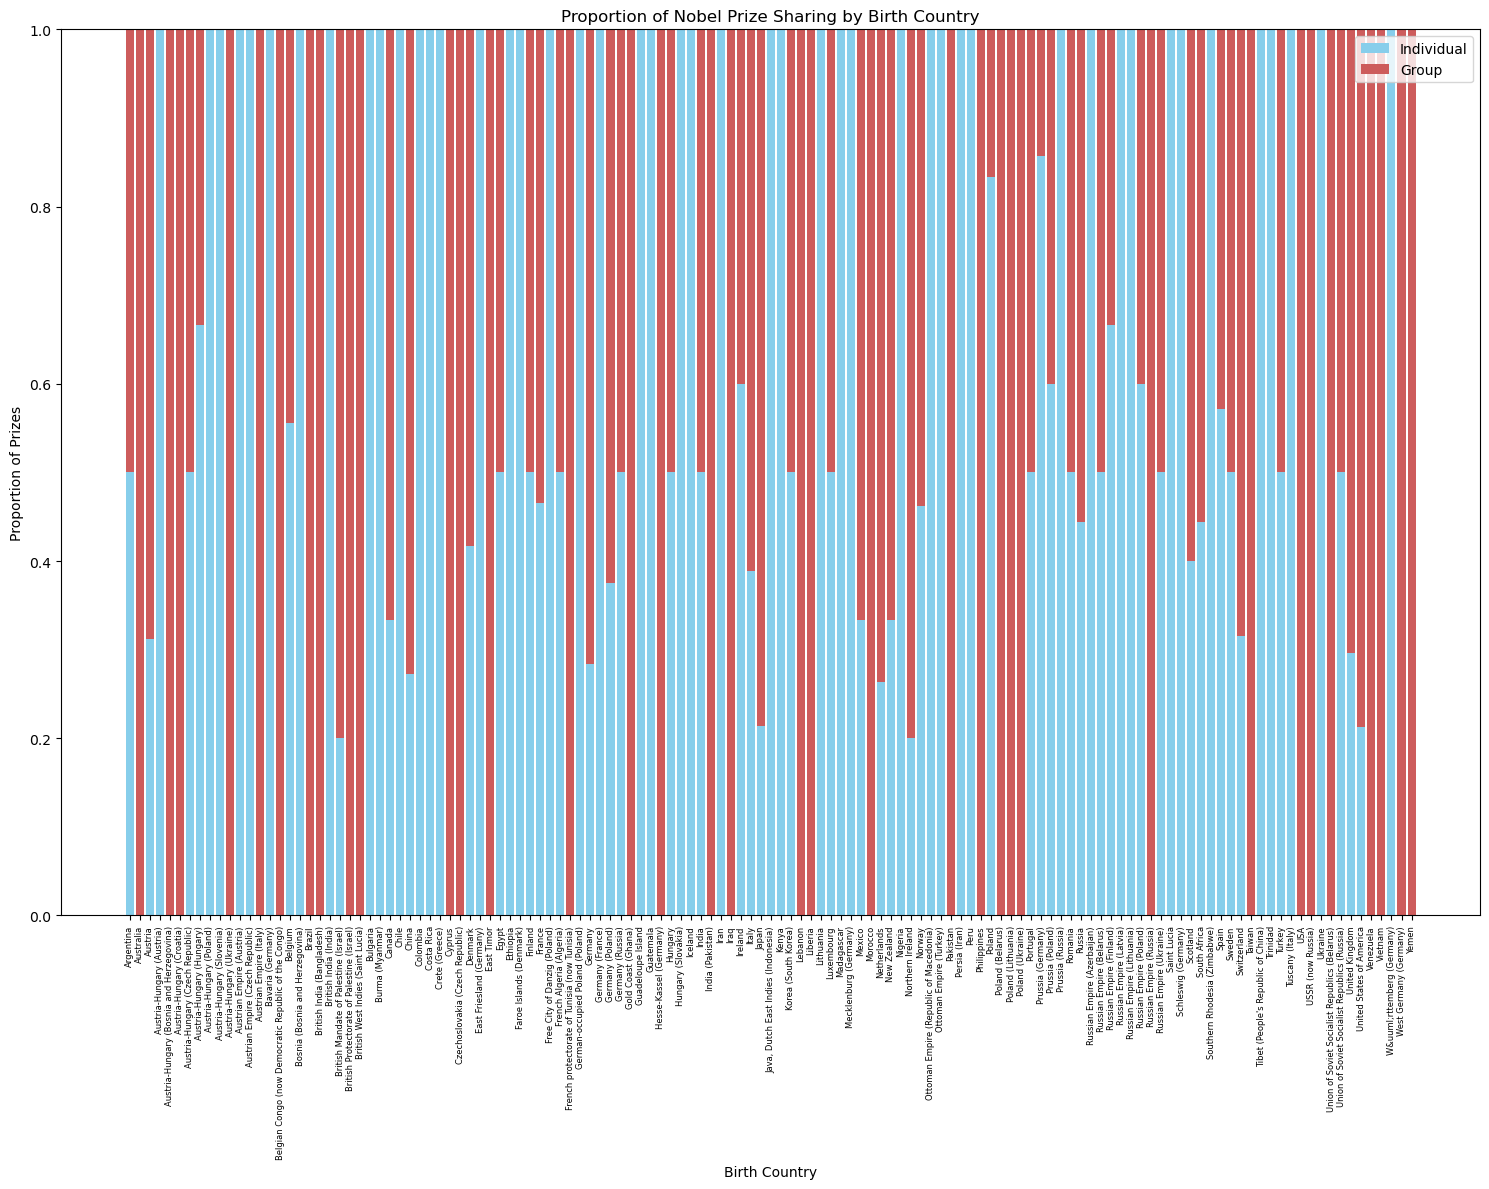

In [38]:
contingency_table['Total'] = contingency_table[0] + contingency_table[1]
contingency_table['Individual Proportion'] = contingency_table[1] / contingency_table['Total']
contingency_table['Group Proportion'] = contingency_table[0] / contingency_table['Total']

countries = contingency_table.index
individual_proportions = contingency_table['Individual Proportion']
group_proportions = contingency_table['Group Proportion']

fig, ax = plt.subplots(figsize=(15, 12))

# Create stacked bars
ax.bar(countries, individual_proportions, label='Individual', color='SkyBlue')
ax.bar(countries, group_proportions, bottom=individual_proportions, label='Group', color='IndianRed')

ax.set_ylabel('Proportion of Prizes')
ax.set_xlabel('Birth Country')
ax.set_title('Proportion of Nobel Prize Sharing by Birth Country')
ax.legend()

plt.xticks(rotation=90, fontsize=6)

plt.tight_layout()
plt.show()

In [39]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2}, p-value: {p}")

Chi-square Statistic: 937.293308763358, p-value: 2.2313841716562336e-27


> The extremely low p-value, much less than the conventional significance level of 0.05, indicates strong evidence to reject the null hypothesis (H0). This suggests that there is a significant association between the laureates' birth countries and the distribution of Nobel Prize sharing.

## 8. Prize_share (Individual Winner vs. Group Winner) & Other Factors 

### 8.1 If a group of people or an organization has a better chance of winning the Nobel Prize than an individual?
When talking about major contributions or breakthroughs in certain areas, the amount of effort and dedication to the area is undoubtably impactful. So, we want to decide if a group of people or an organization has a better chance of winning the Nobel Prize than an individual.

- Null Hypothesis (H0): There is no significant difference in chance of winning Nobel Prize between individual or organizations

- Alternative Hypothesis (H1): The winning rate of Nobel Prize significantly differs between individual competitor and grouped orinization competitor.

In [40]:
# Add a 'decade' column for the Chi-square test
df['decade'] = (df['year'] // 10) * 10

# Chi-square test: Counting the laureates by decade and type
laureate_counts = df.groupby(['decade', 'laureate_type']).size().unstack(fill_value=0)
chi2, p, dof, expected = chi2_contingency(laureate_counts[['Individual', 'Organization']].fillna(0))

# Chi-square test result
print(f"Chi-square Test:")
print(f"Chi2 value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}\n")

Chi-square Test:
Chi2 value: 7.6960673885860045
P-value: 0.8084079360543788
Degrees of freedom: 12



> The Chi-square test results, with a Chi2 value of 7.696 and a P-value of 0.8084 across 12 degrees of freedom, indicate that there is no significant association between the decade groupings and the distribution of Nobel Prizes between individuals and organizations

In [41]:
# Regression analysis: Counting laureates by year and type
yearly_counts = df.groupby(['year', 'laureate_type']).size().unstack(fill_value=0).fillna(0)
X = yearly_counts.index.values
X_sm = sm.add_constant(X)

# Regression for individual laureates
Y_individual = yearly_counts['Individual'].values
model_individual = sm.OLS(Y_individual, X_sm)
results_individual = model_individual.fit()
print("Regression Analysis for Individual Laureates:")
print(results_individual.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Regression Analysis for Individual Laureates:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     247.0
Date:                Sat, 09 Mar 2024   Prob (F-statistic):           1.04e-30
Time:                        10:07:39   Log-Likelihood:                -234.45
No. Observations:                 120   AIC:                             472.9
Df Residuals:                     118   BIC:                             478.5
Df Model:                           1                                   

> The model exhibits a strong relationship with an R-squared value of 0.677, meaning about 67.7% of the variability in the number of individual laureates awarded each year is explained by the year itself. The positive coefficient for the year (0.0690) indicates a significant increasing trend over time for individual laureates, backed by a very low P-value.

<Figure size 1200x600 with 0 Axes>

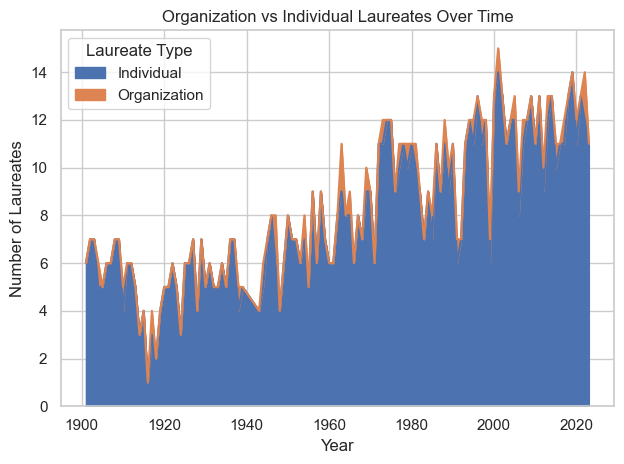

In [42]:
sns.set(style="whitegrid")

# Aggregate the data to count laureates by type for each year
org_vs_ind_yearly = df.groupby(['year', 'laureate_type']).size().unstack(fill_value=0)

# Plot the data
plt.figure(figsize=(12, 6))
org_vs_ind_yearly.plot(kind='area', stacked=True)
plt.title('Organization vs Individual Laureates Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Laureates')
plt.legend(title='Laureate Type')
plt.tight_layout()
plt.show()


We can see the majority of the Nobel Prize reciever are individuals.

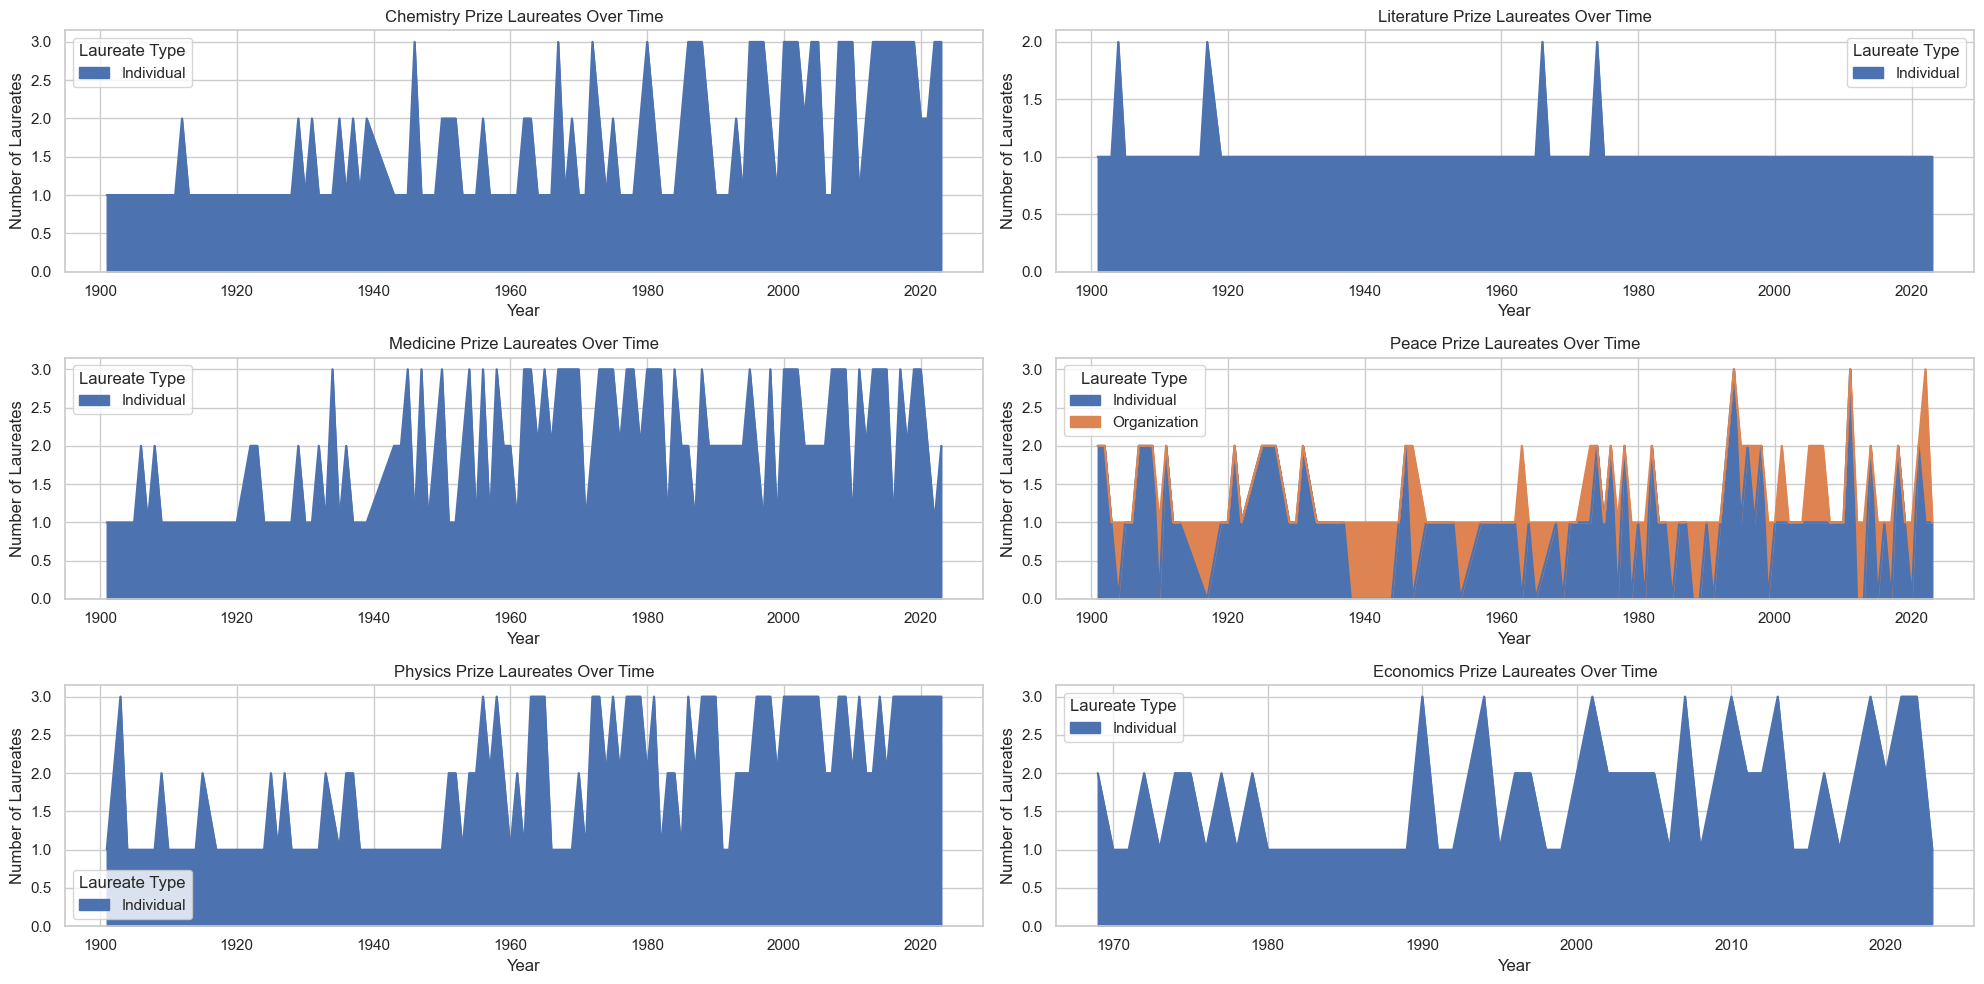

In [43]:
# Setting up the figure for the plots
plt.figure(figsize=(20, 10))

# Getting unique prize categories
prize_categories = df['category'].unique()

# Creating a subplot for each prize category to show trends over time
for index, category in enumerate(prize_categories, 1):
    plt.subplot(3, 2, index)
    category_data = df[df['category'] == category]
    category_yearly = category_data.groupby(['year', 'laureate_type']).size().unstack(fill_value=0)
    category_yearly.plot(kind='area', stacked=True, ax=plt.gca())
    plt.title(f'{category} Prize Laureates Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Laureates')
    plt.legend(title='Laureate Type')

plt.tight_layout()
plt.show()

> We can see that the organization reciever has very low percentage in our dataset. In fact, only the `Peace` prize contains the organizations as reciever. Thus we can conclude that there may continue be an increasing trend in the number of individual laureates over the years, except for the `Peace` prize categroy.

### 8.2 If there is a connection between the prize receiver and the receiver year?
In addition to the individual and organization comparison, another factor we suspect impacts the Nobel Prize recipients a lot is the time and era they are in. We suspect more prizes will be given if there are significant events like technology enhancement or theory breakthroughs. To dive deeper, we want to find if there is a connection between the prize receiver and the receiver year. To be more straightforward, what events impact the prize receiving alongside those times? By the limit time and resources, we only going to focus on the science and techonology related prizes (`Chemistry`, `Medicine`, `Physics`)

In [44]:
# Filter the dataset for science and technology-related categories
science_nobel_data = df[df['category'].isin(['Physics', 'Chemistry', 'Medicine'])]
science_nobel_data.head()

,year,category,prize,motivation,prize_share,laureate_id,laureate_type,full_name,birth_date,birth_city,...,sex,organization_name,organization_city,organization_country,death_date,death_city,death_country,prize_share_numeric,Prize_Individual,decade
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,160,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,...,Male,Berlin University,Berlin,Germany,1911-03-01,Berlin,Germany,1.0,1,1900
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,293,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),...,Male,Marburg University,Marburg,Germany,1917-03-31,Marburg,Germany,1.0,1,1900
5,1901,Physics,The Nobel Prize in Physics 1901,"""in recognition of the extraordinary services ...",1/1,1,Individual,Wilhelm Conrad Röntgen,1845-03-27,Lennep (Remscheid),...,Male,Munich University,Munich,Germany,1923-02-10,Munich,Germany,1.0,1,1900
6,1902,Chemistry,The Nobel Prize in Chemistry 1902,"""in recognition of the extraordinary services ...",1/1,161,Individual,Hermann Emil Fischer,1852-10-09,Euskirchen,...,Male,Berlin University,Berlin,Germany,1919-07-15,Berlin,Germany,1.0,1,1900
8,1902,Medicine,The Nobel Prize in Physiology or Medicine 1902,"""for his work on malaria, by which he has show...",1/1,294,Individual,Ronald Ross,1857-05-13,Almora,...,Male,University College,Liverpool,United Kingdom,1932-09-16,Putney Heath,United Kingdom,1.0,1,1900


In [45]:
# Count the number of prizes awarded each year in each category
awards_count_by_year = science_nobel_data.groupby(['year', 'category']).size().unstack(fill_value=0)

# Sum across categories to get the total number of science and technology prizes per year
awards_count_by_year['Total'] = awards_count_by_year.sum(axis=1)

# Find years with the highest number of total science and technology awards
peak_years = awards_count_by_year['Total'].nlargest(n=10)  # Adjust n for more or fewer years

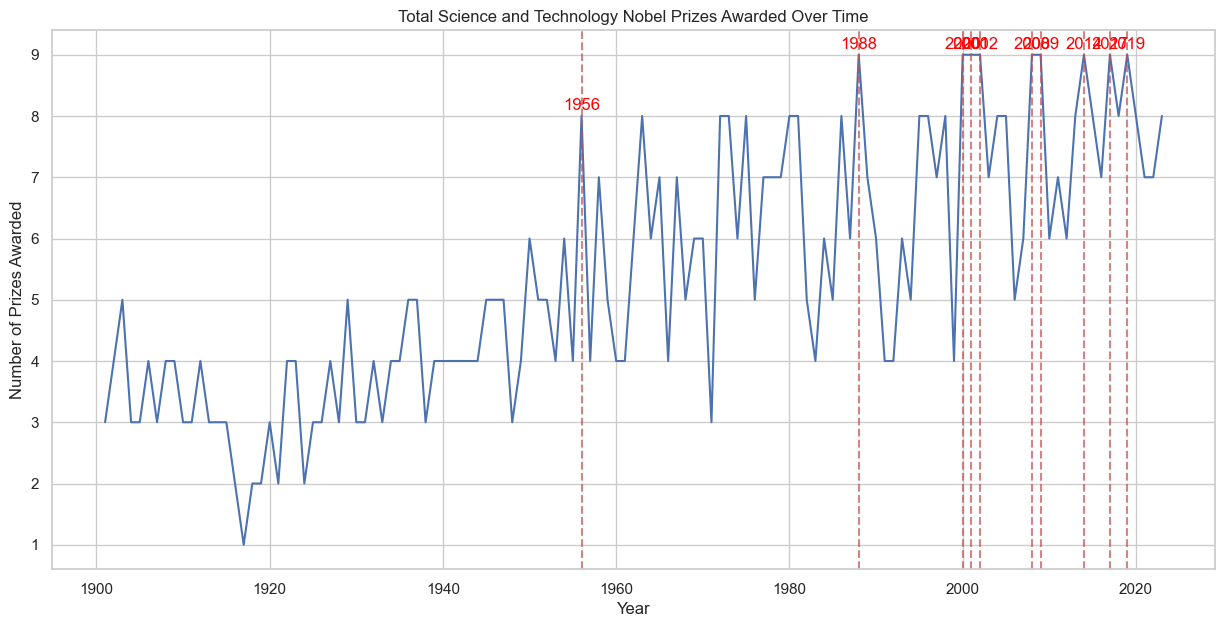

In [46]:
plt.figure(figsize=(15, 7))
awards_count_by_year['Total'].plot(kind='line', title='Total Science and Technology Nobel Prizes Awarded Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Prizes Awarded')

# Highlight peak years
for year in peak_years.index:
    plt.axvline(x=year, color='r', linestyle='--', alpha=0.7)
    plt.text(year, peak_years[year] + 0.1, year, horizontalalignment='center', color='red')

plt.show()

In [47]:
# Count the number of prizes awarded each year in each category
awards_count_by_year = science_nobel_data.groupby(['year', 'category']).size().unstack(fill_value=0)

# Sum across categories to get the total number of science and technology prizes per year
awards_count_by_year['Total'] = awards_count_by_year.sum(axis=1)

# Find years with the highest number of total science and technology awards
peak_years = awards_count_by_year['Total'].nlargest(n=10)  # Adjust 'n' for more or fewer years
print(peak_years)

year
1988    9
2000    9
2001    9
2002    9
2008    9
2009    9
2014    9
2017    9
2019    9
1956    8
Name: Total, dtype: int64


> By doing some background research from Google and Wikipedia, we found:

- The Canadian astronomers Bruce Campbell, G. A. H. Walker, and Stephenson Yang published observations suggesting the existence of an extrasolar planet orbiting the star Gamma Cephei, although this was not confirmed until 2003.
- NASA climate scientist James Hansen brought global warming to public attention through his testimony to the United States Congress, which could have influenced research and awards in environmental sciences.
- The Intergovernmental Panel on Climate Change (IPCC) was established, marking a significant development in climate research efforts.
- In the field of computer science, the Internet saw substantial advancements with the creation of Internet Relay Chat, the first Internet-based chat protocol, and the spread of the Morris worm, the first computer worm distributed via the Internet.
- Tim Berners-Lee began discussing his plans for what would become the World Wide Web at CERN, a breakthrough that revolutionized information sharing and research collaboration globally.

> These events, among others, likely contributed to advancements in science and technology that may have correlated with Nobel Prize awards in subsequent years.

## 9. Interpretation of the Results
- **Gender Analysis**: A significant gender disparity was observed, with males predominating Nobel Prize winners across all categories. However, a positive trend toward increased female representation has emerged, especially post-2000.
- **Birth Country Analysis**: The study revealed a shift from European dominance to significant representation from the United States in Nobel laureates over the 20th century. The Chemistry category exhibited the most considerable shift away from European winners.
- **Prize Sharing**: The data showed a predominant trend of awarding Nobel Prizes to individuals rather than organizations, with the Peace category being an exception where organizational winners are more common.
- **Event Influence**: Peak years of Nobel Prizes in science and technology-related categories suggest a correlation with major global scientific and technological advancements.
- **Overall**: While there has been progress towards gender parity, males significantly outnumber females among laureates. The geographical analysis indicates a shift in Nobel Prize dominance from Europe to the United States, reflecting broader global scientific and technological trends. Moreover, the Nobel Prize continues to favor individual achievements over collaborative or organizational contributions.

## 10. Conclusion and Discussion for Future Work

### 10.1 Conclusion
Our research offers a comprehensive analysis of Nobel Prize winners, highlighting significant gender disparities, geographical dominance shifts, and the preference for individual laureates over organizational ones. Key observations include the persistent male dominance across all prize categories, despite a slow but positive trend toward increased female representation. Additionally, the geographical analysis showcased a notable shift from European to American laureates, reflecting broader historical and scientific trends. Moreover, the overwhelming majority of prizes awarded to individuals rather than organizations underscores the Nobel Prize's emphasis on personal achievement.

### 10.2 Limitation
The primary limitations of our study include its reliance on available datasets, which may not capture the entirety of the Nobel Prize landscape, especially in terms of detailed personal and professional backgrounds of the laureates. Furthermore, the analysis of interdisciplinary research and its recognition by the Nobel Prize committees remains unexplored due to dataset constraints. Additionally, while this study provides insights into trends and disparities, it does not delve deeply into the underlying causes or the impact of these findings on the global scientific and cultural communities.

### 10.3 Future Work
Future research should focus on addressing the current study's limitations and expanding its scope to include more nuanced analyses. Interdisciplinary Research deserves particular attention, considering the growing importance of cross-disciplinary innovations in addressing complex global challenges. Future studies should explore:
- **Interdisciplinary Research**: Explore how interdisciplinary research is awarded in the Nobel Prize context, considering the growing importance of cross-disciplinary innovations.
- **Impact of Nobel Prizes**: Assessing the long-term impact of Nobel Prize recognition on the laureates' careers, their fields of study, and broader societal implications.
- **Emerging Scientific Powers**: Examining the representation and recognition of laureates from emerging scientific powers outside the traditional Western dominance, to understand the shifting landscape of global science and innovation.